In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def lift(x, i, offset, vals):
    v = x[i + offset] * vals[0]
    if len(vals) > 1:
        return v + lift(x, i, offset + 1, vals[1:])
    else:
        return v

def bc_zero(x, i, n, offset, vals, verbose=False):
    io = i + offset
    if io >= n:
        return x.dtype.type(0.0)
    elif io < 0:
        if len(vals) > 1:
            return bc_zero(x, i, n, offset + 1, vals[1:])
        else:
            return x.dtype.type(0.0)

    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + bc_zero(x, i, n, offset + 1, vals[1:])
    else:
        return v

def bc_wrap(x, i, n, offset, vals, verbose=False):
    if io < 0 or io >= n:
        io = (i + offset) % n

    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + bc_wrap(x, i, n, offset + 1, vals[1:])
    else:
        return v

def bc_const(x, i, n, offset, vals, verbose=False):
    io = i + offset
    if io > n - 1:
        io = n - 1
    elif io < 0:
        io = 0
    
    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + bc_const(x, i, n, offset + 1, vals[1:])
    else:
        return v

def bc_symm(x, i, n, offset, vals, verbose=False):
    io = i + offset
    while io < 0 or io >= n:
        if io < 0:
            io = - (io + 1)
        elif io >= n:
            io = 2 * (n - 1) - (io - 1)

    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + bc_symm(x, i, n, offset + 1, vals[1:])
    else:
        return v


def bc_refl(x, i, n, offset, vals, verbose=False):
    io = i + offset
    while io < 0 or io >= n:
        if io < 0:
            io = -io
        elif io >= n:
            io = 2 * (n - 1) - io

    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + bc_refl(x, i, n, offset + 1, vals[1:])
    else:
        return v

In [3]:
class lift_zero_adj:
    @staticmethod
    def front_loop(x, y, vals_r, offset_r, verbose=False):
        pass

    @staticmethod
    def end_loop(x, y, vals_r, offset_r, verbose=False):
        pass

class lift_wrap_adj:
    # x => s
    # y => d
    @staticmethod
    def front_loop(x, y, vals_r, offset_r, verbose=False):
        nx = len(x)
        ny = len(y)
        n_vals = len(vals_r)

        offset = 1 - offset_r - n_vals
        i_back = 1

        if verbose:
            print(offset, i_back)
            
        for ix in range(offset, 0):
            i_start = max(0, i_back - n_vals)
            i_end = min(ny, i_back)

            io = ix % nx
            i_v = n_vals - i_back
            if verbose:
                print(ix, io, i_v, i_start, i_end)
                
            v = 0.0
            for iy in range(i_start, i_end):
                v += vals_r[i_v + iy] * y[iy]
            x[io] += v

            i_back += 1

    @staticmethod
    def end_loop(x, y, vals_r, offset_r, verbose=False):
        nx = len(x)
        ny = len(y)
        n_vals = len(vals_r)
        offset = 1 - offset_r - n_vals

        i_front = ny + offset_r
        if verbose:
            print(nx, nx - offset_r)

        for ix in range(ny, ny - offset_r):
            i_start = max(i_front, 0)
            i_end = min(ny, i_front + n_vals)

            io = ix % nx
            i_v = max(0, -i_front)
            if io != ix: # causes a skip for nx != ny
                if verbose:
                    print(ix, io, i_v, i_start, i_end)
                v = 0.0
                for iy in range(i_start, i_end):
                    v += vals_r[i_v] * y[iy]
                    i_v += 1
                x[io] += v

            i_front += 1

class lift_const_adj:
    @staticmethod
    def front_loop(x, y, vals_r, offset_r, verbose=False):
        nx = len(x)
        ny = len(y)
        n_vals = len(vals_r)

        offset = 1 - offset_r - n_vals
        i_back = 1

        if verbose:
            print(offset, i_back)
            
        for ix in range(offset, 0):
            i_start = max(0, i_back - n_vals)
            i_end = min(ny, i_back)

            io = 0
            i_v = n_vals - i_back
            if verbose:
                print(ix, io, i_v, i_start, i_end)
                
            v = 0.0
            for iy in range(i_start, i_end):
                v += vals_r[i_v + iy] * y[iy]
            x[io] += v

            i_back += 1

    @staticmethod
    def end_loop(x, y, vals_r, offset_r, verbose=False):
        nx = len(x)
        ny = len(y)
        n_vals = len(vals_r)

        offset = 1 - offset_r - n_vals
        i_back = 1

        if verbose:
            print(nx, nx - offset_r)

        i_front = ny + offset_r
        for ix in range(ny, ny - offset_r):
            i_start = max(i_front, 0)
            i_end = min(ny, i_front + n_vals)

            io = min(ix, nx - 1)
            i_v = max(0, -i_front)
            if io != ix: # causes a skip for nx != ny
                if verbose:
                    print(ix, io, i_v, i_start, i_end)
                v = 0.0
                for iy in range(i_start, i_end):
                    v += vals_r[i_v] * y[iy]
                    i_v += 1
                x[io] += v

            i_front += 1

class lift_symm_adj:
    @staticmethod
    def front_loop(x, y, vals_r, offset_r, verbose=False):
        nx = len(x)
        ny = len(y)
        n_vals = len(vals_r)

        offset = 1 - offset_r - n_vals
        i_back = 1

        if verbose:
            print(offset, i_back)
            
        for ix in range(offset, 0):
            i_start = max(0, i_back - n_vals)
            i_end = min(ny, i_back)

            io = ix
            while io >= nx or io < 0:
                if io < 0:
                    io = - (io + 1)
                elif io >= nx:
                    io = 2 * (nx - 1) - (io - 1)

            i_v = n_vals - i_back
            if verbose:
                print(ix, io, i_v, i_start, i_end)
                
            v = 0.0
            for iy in range(i_start, i_end):
                v += vals_r[i_v + iy] * y[iy]
            x[io] += v

            i_back += 1

    @staticmethod
    def end_loop(x, y, vals_r, offset_r, verbose=False):
        nx = len(x)
        ny = len(y)
        n_vals = len(vals_r)

        offset = 1 - offset_r - n_vals
        i_back = 1

        if verbose:
            print(nx, nx - offset_r)

        i_front = ny + offset_r
        for ix in range(ny, ny - offset_r):
            i_start = max(i_front, 0)
            i_end = min(ny, i_front + n_vals)

            # io = min(ix, nx - 1)
            io = ix
            while io >= nx or io < 0:
                if io < 0:
                    io = -io - 1
                elif io >= nx:
                    io = nx - (io - nx) - 1

            i_v = max(0, -i_front)
            if io != ix: # causes a skip for nx != ny
                if verbose:
                    print(ix, io, i_v, i_start, i_end)
                v = 0.0
                for iy in range(i_start, i_end):
                    v += vals_r[i_v] * y[iy]
                    i_v += 1
                x[io] += v

            i_front += 1

In [4]:
def bc_zero_long(x, i, n, offset, vals, verbose=False):
    io = i + offset
    n_vals = len(vals)

    v = 0.0
    ii = 0
    js = []
    for j in range(io, io + n_vals):
        if j >= 0 and j < n:
            v += x[j] * vals[ii]
            js.append(j)
        ii += 1
    if verbose:
        print(i, js)
    return v

def bc_wrap_long(x, i, n, offset, vals, verbose=False):
    io = i + offset
    n_vals = len(vals)

    v = 0.0
    ii = 0
    js = []
    for j in range(io, io + n_vals):
        j = j % n
        v += x[j] * vals[ii]
        js.append(j)
        ii += 1
    if verbose:
        print(i, js)
    return v

def bc_const_long(x, i, n, offset, vals, verbose=False):
    io = i + offset
    n_vals = len(vals)

    v = 0.0
    ii = 0
    js = []
    for j in range(io, io + n_vals):
        j = max(j, 0)        
        j = min(j, n - 1)
        v += x[j] * vals[ii]
        js.append(j)
        ii += 1
    if verbose:
        print(i, js)
    return v

def bc_symm_long(x, i, n, offset, vals, verbose=False):
    # repeats the value at the end
    io = i + offset
    n_vals = len(vals)

    v = 0.0
    ii = 0
    js = []
    for j in range(io, io + n_vals):
        while j < 0 or j >= n:
            if j < 0:
                j = - (j + 1)
            elif j >= n:
                j = 2 * (n - 1) - (j - 1)

        v += x[j] * vals[ii]
        js.append(j)
        ii += 1
    if verbose:
        print(i, js)
    return v

def bc_refl_long(x, i, n, offset, vals, verbose=False):
    # does not repeat edge values
    io = i + offset
    n_vals = len(vals)

    v = 0.0
    ii = 0
    js = []
    for j in range(io, io + n_vals):
        while j < 0 or j >= n:
            if j < 0:
                j = - j
            elif j >= n:
                j = 2 * (n - 1) - j

        v += x[j] * vals[ii]
        js.append(j)
        ii += 1
    if verbose:
        print(i, js)
    return v

In [5]:
class update_d:
    
    def __init__(self, offset, vals):
        self.vals = np.asarray(vals, dtype=np.float64).copy()
        self.offset = offset
        self.n_front = 0 if offset > 0 else -offset

        n_vals = len(vals)
        max_off = n_vals - 1 + offset
        self.n_back = 0 if max_off < 0 else max_off

        self.offset_r = -max_off
        self.n_front_r = 0 if self.offset_r > 0 else -self.offset_r
        
        max_off_r = n_vals - 1 + self.offset_r
        self.n_back_r = 0 if max_off_r < 0 else max_off_r

    def forward(self, s, d, bc, verbose=False) -> None:
        ns = len(s)
        nd = len(d)
        vals = self.vals.astype(s.dtype)

        # s indices from offset to min(n_front, nd) + offset + n_vals
        for i in range(min(self.n_front, nd)):
            # s indices are from i + offset to i + offset + n_vals
            d[i] += bc(s, i, ns, self.offset, vals, verbose=verbose)

        # touches s indices from n_front + offset to nd - n_back + offset + n_vals 
        for i in range(self.n_front, nd - self.n_back):
            # s indices are from i + offset to i + offset + n_vals
            d[i] += lift(s, i, self.offset, vals)

        # touches j indices from max(nd - n_back, 0) + offset to nd + offset + n_vals
        for i in range(max(nd - self.n_back, 0), nd):
            # s indices are from i + offset to i + offset + n_vals
            d[i] += bc(s, i, ns, self.offset, vals, verbose=verbose)

    def forward_adj(self, s, d, bc_adj, verbose=False) -> None:
        ns = len(s)
        nd = len(d)

        vals = self.vals.astype(s.dtype)
        offset = self.offset
        
        vals_r = self.vals[::-1].astype(s.dtype).copy()
        offset_r = self.offset_r

        n_vals = len(vals)

        if verbose: print("front loop")
        bc_adj.front_loop(s, d, vals_r, offset_r, verbose=verbose)
        
        for i in range(min(self.n_front_r, ns)):
            # s indices are from i + offset to i + offset + n_vals
            s[i] += bc_zero(d, i, nd, offset_r, vals_r)
        for i in range(self.n_front_r, nd - self.n_back_r):
            s[i] += lift(d, i, offset_r, vals_r)
        for i in range(max(nd - self.n_back_r, 0), ns):
            # s indices are from i + offset to i + offset + n_vals
            s[i] += bc_zero(d, i, nd, offset_r, vals_r)

        if verbose: print("end loop")
        bc_adj.end_loop(s, d, vals_r, offset_r, verbose=verbose)


In [6]:
def forward_transform(wvlt, x, mode="periodic", verbose=False):
    if mode == 'periodic':
        bc = bc_wrap_long
    elif mode == 'zero':
        bc = bc_zero_long
    elif mode == 'constant':
        bc = bc_const_long
    elif mode == 'symmetric':
        bc = bc_symm_long
    elif mode == 'reflect':
        bc = bc_refl_long

    s = x[::2].copy()
    d = x[1::2].copy()

    for step in wvlt.steps:
        step.forward(s, d, bc, verbose=verbose)

    return s, d

def forward_transform_adj(wvlt, s, d, mode="periodic", verbose=False):
    if mode == 'periodic':
        bc = lift_wrap_adj
    elif mode == 'zero':
        bc = lift_zero_adj
    elif mode == 'constant':
        bc = lift_const_adj
    elif mode == 'symmetric':
        bc = lift_symm_adj
    elif mode == 'reflect':
        bc = lift_refl_adj

    s = s.copy()
    d = d.copy()

    for step in wvlt.steps[::-1]:
        step.forward_adj(s, d, bc, verbose=verbose)

    x = np.empty(len(s) + len(d), dtype=s.dtype)
    x[::2] = s
    x[1::2] = d
    return x

In [7]:
def get_mats(wvlt, mode, n, verbose=1):
    fwd_mats = []
    fwd_adj_mats = []

    for i in range(n):
        e = np.zeros(n)
        e[i] = 1
        nd = len(e)//2
        ns = len(e) - nd
        es = e[:ns]
        ed = e[ns:]
        
        # s, d = forward_transform(TestDWavelet, e, mode=mode)
        # for_mats.append(np.r_[s, d])
        s, d = forward_transform(wvlt, e, mode=mode, verbose=verbose)
        fwd_mats.append(np.r_[s, d])
    
        fwd_adj_mats.append(forward_transform_adj(wvlt, es, ed, mode=mode, verbose=verbose))

        verbose = 0

    fwd_mats = np.stack(fwd_mats, axis=1)
    fwd_adj_mats = np.stack(fwd_adj_mats, axis=1)
    return fwd_mats, fwd_adj_mats

In [8]:
class lift_refl_adj:
    @staticmethod
    def front_loop(x, y, vals_r, offset_r, verbose=False):
        nx = len(x)
        ny = len(y)
        n_vals = len(vals_r)

        offset = 1 - offset_r - n_vals
        i_back = 1

        if verbose:
            print(offset, i_back)
            
        for ix in range(offset, 0):
            i_start = max(0, i_back - n_vals)
            i_end = min(ny, i_back)

            io = ix
            while io >= nx or io < 0:
                if io < 0:
                    io = - io
                elif io >= nx:
                    io = 2 * (nx - 1) - io

            i_v = n_vals - i_back
            if verbose:
                print(ix, io, i_v, i_start, i_end)
                
            v = 0.0
            for iy in range(i_start, i_end):
                v += vals_r[i_v + iy] * y[iy]
            x[io] += v

            i_back += 1

    @staticmethod
    def end_loop(x, y, vals_r, offset_r, verbose=False):
        nx = len(x)
        ny = len(y)
        n_vals = len(vals_r)

        offset = 1 - offset_r - n_vals
        i_back = 1

        if verbose:
            print(nx, nx - offset_r)

        i_front = ny + offset_r
        for ix in range(ny, ny - offset_r):
            i_start = max(i_front, 0)
            i_end = min(ny, i_front + n_vals)

            io = ix
            while io >= nx or io < 0:
                if io < 0:
                    io = - io
                elif io >= nx:
                    io = 2 * (nx - 1) - io

            i_v = max(0, -i_front)
            if io != ix: # causes a skip for nx != ny
                if verbose:
                    print(ix, io, i_v, i_start, i_end)
                v = 0.0
                for iy in range(i_start, i_end):
                    v += vals_r[i_v] * y[iy]
                    i_v += 1
                x[io] += v

            i_front += 1

In [9]:
class TestDWavelet:
    steps = (
        update_d(-3, [2, 3, 5, 8, 11, 15, 20]),
    )

In [10]:
# -1 gets... 7, 8, 9, 10, 11, 12, 13
# -2 gets... 6, 7, 8, 9, 10, 11, 12

0 [13, 14, 15, 0, 1, 2, 3]
1 [14, 15, 0, 1, 2, 3, 4]
2 [15, 0, 1, 2, 3, 4, 5]
12 [9, 10, 11, 12, 13, 14, 15]
13 [10, 11, 12, 13, 14, 15, 0]
14 [11, 12, 13, 14, 15, 0, 1]
front loop
-3 1
-3 13 6 0 1
-2 14 5 0 2
-1 15 4 0 3
end loop
16 19
16 0 0 13 15
17 1 0 14 15


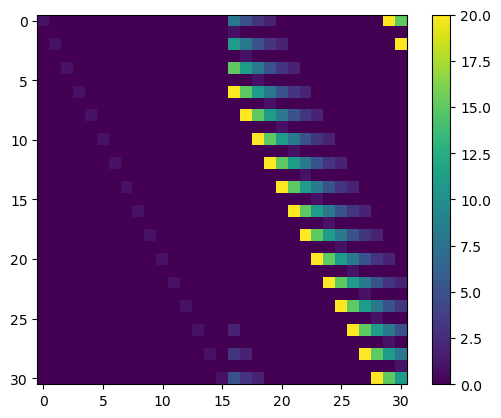

In [17]:
n = 31
fwd_mats, fwd_adj_mats = get_mats(TestDWavelet, 'periodic', n=n)
fwd_mats0, fwd_adj_mats0 = get_mats(TestDWavelet, 'zero', n=n, verbose=0)
plt.imshow(fwd_mats.T)
# plt.imshow(fwd_mats.T)
plt.colorbar()

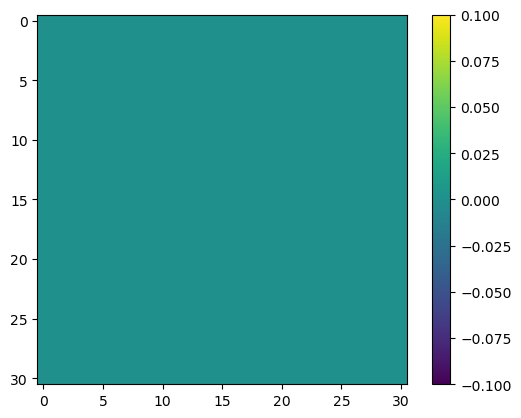

In [18]:
plt.imshow(fwd_adj_mats - fwd_mats.T)
# plt.imshow(fwd_adj_mats)
plt.colorbar()